In [1]:
import sys
sys.path.append('../')

from common_imports import *
from common_functions import *

In [2]:
df = pd.read_csv("lookup.csv")
df, weather_features = preprocess_df(df)
sequence_length = 15

In [17]:
weather_features

['temp',
 'dew',
 'precip',
 'precipcover',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'solarradiation',
 'elevation']

In [3]:
df.columns

Index(['name', 'datetime', 'temp', 'dew', 'precip', 'precipcover', 'snow',
       'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'solarradiation', 'county', 'elevation', 'OptimizedSeverityScore_Log',
       'FireOccurred'],
      dtype='object')

In [4]:
avant_2018 = df[(df['datetime'] < '2018-01-01')]
apres_2018 = df[(df['datetime'] >= '2018-01-01')]
counties = df['county'].unique()
cities = df['name'].unique()

In [6]:
X_train, X_val, X_test = train_val_test(avant_2018, apres_2018, cities, sequence_length, weather_features)

# Ensure fire labels are integers
X_train['y_fire'] = X_train['y_fire'].astype(int)
X_val['y_fire'] = X_val['y_fire'].astype(int)
X_test['y_fire'] = X_test['y_fire'].astype(int)

In [10]:
X_train_array, X_val_array, y_train_fire, y_train_severity, y_val_fire, y_val_severity = setup_x_and_y(X_train, X_val)

In [11]:
print(f"X_train shape: {X_train_array.shape}")
print(f"X_test shape: {X_val_array.shape}")
print(f"y_train_fire shape: {y_train_fire.shape}")
print(f"y_train_severity shape: {y_train_severity.shape}")

X_train shape: (85313, 15, 10)
X_test shape: (31480, 15, 10)
y_train_fire shape: (85313,)
y_train_severity shape: (85313,)


In [12]:
X_train_rf = X_train_array.reshape(X_train_array.shape[0], -1)
X_val_rf = X_val_array.reshape(X_val_array.shape[0], -1)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Models
# Likelihood Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_rf, y_train_fire)


# Predictions
likelihood_pred = clf.predict(X_val_rf)

# Evaluation
accuracy = accuracy_score(y_val_fire, likelihood_pred)
f1score = f1_score(y_val_fire, likelihood_pred)

print(f"Likelihood Prediction Accuracy: {accuracy}")
print(f"Likelihood Prediction F1-score: {f1score}")


Likelihood Prediction Accuracy: 0.7081321473951715
Likelihood Prediction F1-score: 0.8075730920666834


In [14]:
print(classification_report(y_val_fire, likelihood_pred))
print(confusion_matrix(y_val_fire, likelihood_pred))

              precision    recall  f1-score   support

           0       0.25      0.98      0.40      3089
           1       1.00      0.68      0.81     28391

    accuracy                           0.71     31480
   macro avg       0.62      0.83      0.60     31480
weighted avg       0.92      0.71      0.77     31480

[[ 3012    77]
 [ 9111 19280]]


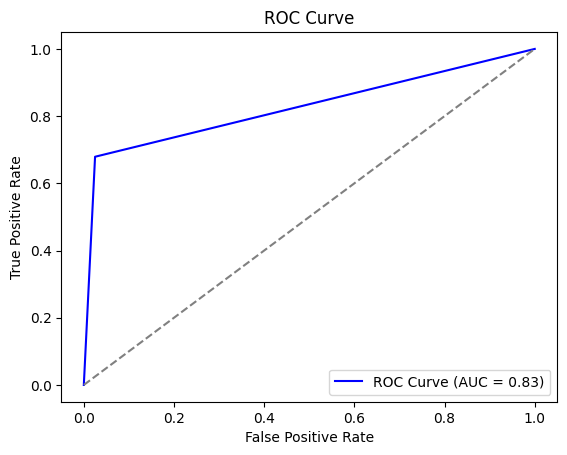

In [15]:
# Assuming you have predictions and true labels
fpr, tpr, thresholds = roc_curve(y_val_fire, likelihood_pred)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

In [16]:
# Severity Model
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_rf, y_train_severity)

severity_pred = reg.predict(X_val_rf)

mse = mean_squared_error(y_val_severity, severity_pred)

print(f"Severity Prediction MSE: {mse}")


Severity Prediction MSE: 1.672581493106564


A lower MSE indicates better model performance, as the predictions are closer to the actual values.
In your case, 1.6263 is the average squared error. 